In [1]:
import chromadb
import time

import jsonlines
from tqdm.notebook import tqdm
from collections import defaultdict

from matplotlib import pyplot as plt

import polars as pl
import pandas as pd
import numpy as np

from code.fasttext.embedding_utils import TableEncoder, compare_embeddings
from code.utils.utils import rebuild_table
from code.utils.settings import DefaultPath

In [2]:
tabenc = TableEncoder ()

In [3]:
chroma_client = chromadb.PersistentClient(
    # DefaultPath.db_path.chroma + 'double_collection_v1/' + 'v_35_50000_add_label_True_with_metadatas_True'
    DefaultPath.db_path.chroma + 'double_collection_v1/' + 'v_31_25000_add_label_True_with_metadatas_True'
    )
chroma_client.list_collections()

[Collection(name=columns), Collection(name=rows)]

In [4]:
row_collection = chroma_client.get_collection('rows')
column_collection = chroma_client.get_collection('columns')

In [5]:
sloth_tables = {json_table['_id']: rebuild_table(json_table) 
             for i, json_table in enumerate(jsonlines.open(DefaultPath.data_path.wikitables + 'sloth_tables.jsonl'))
             if i < 25000}

In [6]:
sloth_results = pl.read_csv(DefaultPath.data_path.wikitables + 'train_set_turl_malaguti.csv') \
                    .sort(by=['o_a', 'jsim', 'a%'], descending=[True, True, True])

In [7]:
in_db = sloth_results[['r_id', 's_id']].apply(lambda x: x[0] in sloth_tables.keys() and x[1] in sloth_tables.keys())
sloth_results = sloth_results.with_columns(pl.Series(name='in-db', values=in_db)).filter(pl.col('in-db') == True).drop('in-db')

In [8]:
sloth_results.head()

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491
"""16517223-1""","""16519520-1""",0.915589,1640,0.622627
"""16682980-1""","""16717744-1""",0.863576,1590,0.600907
"""16559174-1""","""16682980-1""",0.842894,1465,0.549925
"""16519520-1""","""16559174-1""",0.867637,1345,0.51063


# Computing the similarity mean to rank the tables

## Test 1: Low Jaccard - High Overlap

In [110]:
idx_row = 0
sloth_result_rec = sloth_results[idx_row]
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491


In [70]:
r_id = sloth_result_rec['r_id'].item()
s_id = sloth_result_rec['s_id'].item()
r_table = sloth_tables[r_id]
s_table = sloth_tables[s_id]

r_row_embeddings, r_column_embeddings = tabenc.full_embedding(r_table, True)
r_row_embeddings.shape, r_column_embeddings.shape 

((265, 300), (7, 300))

In [71]:
r_table.head()

,Name,Rural municipality (RM),Population (2011),Population (2006),Change (%),Land area (km²),Population density (per km²)
0,Abbey,Miry Creek No. 229,115,130,-11.5,0.77,149.1
1,Abernethy,Abernethy No. 186,196,197,-0.5,1.03,189.9
2,Albertville,Wise Creek No. 77,140,110,27.3,1.12,124.7
3,Alida,Reciprocity No. 32,131,106,23.6,0.37,357.1
4,Alvena,Fish Creek No. 402,55,55,0,0.43,128


In [72]:
s_table.head()

,Name,Status,Rural municipality,Population (2011),Population (2006),Change (%),Land area (km²),Population density (per km 2 )
0,Estevan,City,Estevan No. 5,11054,10084,9.6,18.85,586.6
1,Flin Flon (part),City,—,"229 This population does not include 5,363 in ...",242,-5.4,2.37 This area does not include km2 (sqmi) in ...,96.4
2,Humboldt,City,Humboldt No. 370,5678,4998,13.6,13.46,421.9
3,Lloydminster (part) The balance of Lloydminste...,City,Britannia No. 502,"9772 This population does not include 18,032 i...",8118,20.4,17.34 This area does not include km2 (sqmi) in...,563.6
4,Martensville Martensville is Saskatchewan's sm...,City,Corman Park No. 344,7716,4978,55,6.23,1239.3


### Row querying

In [79]:
res = row_collection.query(
    query_embeddings=r_row_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [76]:
row_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        row_tid_freq_simlist[single_rec['table_id']].append(res['distances'][i][j])

In [91]:
row_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), row_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
row_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True, ignore_index=True)
row_freq_avgcos_df = row_freq_avgcos_df[row_freq_avgcos_df['freq'] > 1].reset_index().drop('index', axis=1)
row_freq_avgcos_df.head(10)

,table_id,freq,avg-cosine-distance
0,31485195-15,7,0.016165
1,17785973-1,2,0.016683
2,17790191-2,2,0.017373
3,20846402-3,8,0.017820
4,3623768-4,5,0.019024
5,37953453-1,2384,0.019614
6,20840027-3,4,0.021972
7,2064943-1,3,0.022173
8,601446-2,2,0.022264
9,3624090-3,2,0.022752


In [96]:
s_id_idx = 5

sloth_tables[row_freq_avgcos_df.loc[s_id_idx, 'table_id']]

,Name,Status,Rural municipality,Population (2011),Population (2006),Change (%),Land area (km²),Population density (per km 2 )
0,Estevan,City,Estevan No. 5,11054,10084,9.6,18.85,586.6
1,Flin Flon (part),City,—,"229 This population does not include 5,363 in ...",242,-5.4,2.37 This area does not include km2 (sqmi) in ...,96.4
2,Humboldt,City,Humboldt No. 370,5678,4998,13.6,13.46,421.9
3,Lloydminster (part) The balance of Lloydminste...,City,Britannia No. 502,"9772 This population does not include 18,032 i...",8118,20.4,17.34 This area does not include km2 (sqmi) in...,563.6
4,Martensville Martensville is Saskatchewan's sm...,City,Corman Park No. 344,7716,4978,55,6.23,1239.3
...,...,...,...,...,...,...,...,...
466,West End,Resort village,Fertile Belt No. 183,17,26,-34.6,0.34,50.4
467,Total City,–,–,595678,547615,8.8,675.25,811.0
468,Total Town,–,–,137611,127795,7.7,473.50,290.6
469,Total Village,–,–,43130,41091,5.0,302.29,142.7


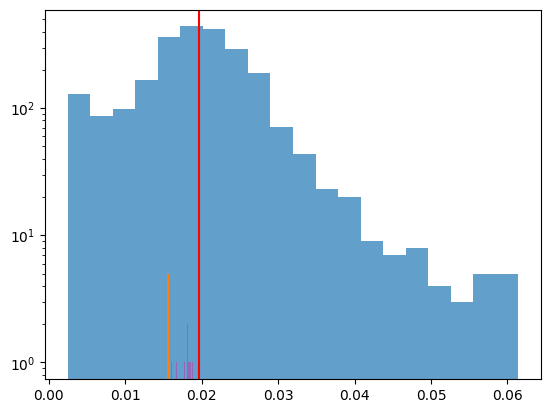

In [102]:
plt.yscale('log')
plt.hist(row_tid_freq_simlist[row_freq_avgcos_df.loc[s_id_idx, 'table_id']], bins=20, alpha=0.7)
for idx in range(0, s_id_idx - 1):
    plt.hist(row_tid_freq_simlist[row_freq_avgcos_df.loc[idx, 'table_id']], bins=20)

plt.axvline(x=row_freq_avgcos_df.loc[s_id_idx, 'avg-cosine-distance'], color='r')
plt.show()

### Column querying

In [103]:
col_res = column_collection.query(
    query_embeddings=r_column_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [104]:
col_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(col_res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        col_tid_freq_simlist[single_rec['table_id']].append(col_res['distances'][i][j])

In [108]:
col_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), col_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
col_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)

# discarding tables which appears only once, since they aren't actually significative
col_freq_avgcos_df[col_freq_avgcos_df['freq'] > 1].head()

,table_id,freq,avg-cosine-distance
58,20010164-2,4,0.001194
62,5116633-1,2,0.001388
64,33895892-8,2,0.001460
0,37953453-1,9,0.002979
39,10848656-1,2,0.005462


In [112]:
col_freq_avgcos_df.sort_values(by=['freq', 'avg-cosine-distance'], ascending=[False, True]).head()

,table_id,freq,avg-cosine-distance
0,37953453-1,9,0.002979
58,20010164-2,4,0.001194
62,5116633-1,2,0.001388
64,33895892-8,2,0.001460
39,10848656-1,2,0.005462


In [106]:
s_id

'37953453-1'

### Conclusions

In [109]:
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491


Nonostante la jsim molto bassa, anche in questo caso nel ranking sia tra colonne che tra righe la s_table di partenza è prima se si considera innnanzitutto la frequenza come fattore di ordinamento, altrimenti con la cosine distance media è comunque tra le prime

Come relazionare bene eventualmente questi due parametri?

## Test 2: High Jaccard - High Overlap

In [113]:
idx_row = 1
sloth_results[idx_row]

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""16517223-1""","""16519520-1""",0.915589,1640,0.622627


In [ ]:
r_id = sloth_result_rec['r_id'].item()
s_id = sloth_result_rec['s_id'].item()
r_table = sloth_tables[r_id]
s_table = sloth_tables[s_id]

r_row_embeddings, r_column_embeddings = tabenc.full_embedding(r_table, True)
r_row_embeddings.shape, r_column_embeddings.shape 

((441, 300), (6, 300))

In [ ]:
r_table.head()

,Rank,Representative,Party,District,Seniority date,Notes
0,1,John Dingell,D,MI-15,"December 13, 1955",
1,2,John Conyers,D,MI-14,"January 3, 1965",
2,3,Dave Obey,D,WI-7,"April 1, 1969",
3,4,Charles B. Rangel,D,NY-15,"January 3, 1971",
4,5,Bill Young,R,FL-10,"January 3, 1971",


In [ ]:
s_table.head()

,Rank,Representative,Party,District,Seniority date,Notes
0,1,John Dingell,D,MI-15,"December 13, 1955",
1,2,John Conyers,D,MI-14,"January 3, 1965",
2,3,Dave Obey,D,WI-7,"April 1, 1969",
3,4,Phil Crane,R,IL-08,"November 25, 1969",Left the House in 2005 .
4,5,Charles B. Rangel,D,NY-15,"January 3, 1971",


### Row querying

In [ ]:
res = row_collection.query(
    query_embeddings=r_row_embeddings.tolist(),
    n_results=10,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [ ]:
row_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        row_tid_freq_simlist[single_rec['table_id']].append(res['distances'][i][j])

In [ ]:
row_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), row_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
row_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)
row_freq_avgcos_df.head()

,table_id,freq,avg-cosine-distance
0,16519520-1,1228,0.020223
1,16559174-1,1061,0.021192
2,16682980-1,1042,0.021215
3,16717744-1,932,0.021343
50,34292050-5,1,0.029258


In [ ]:
s_id

'16519520-1'

In [ ]:
s_id_idx = 0

In [ ]:
sloth_tables[row_freq_avgcos_df.loc[s_id_idx, 'table_id']]

,Rank,Representative,Party,District,Seniority date,Notes
0,1,John Dingell,D,MI-15,"December 13, 1955",
1,2,John Conyers,D,MI-14,"January 3, 1965",
2,3,Dave Obey,D,WI-7,"April 1, 1969",
3,4,Phil Crane,R,IL-08,"November 25, 1969",Left the House in 2005 .
4,5,Charles B. Rangel,D,NY-15,"January 3, 1971",
...,...,...,...,...,...,...
434,435,Chris Van Hollen,D,MD-8,"January 3, 2003",
435,,Randy Neugebauer,R,TX-19,"June 3, 2003",
436,,Ben Chandler,D,KY-6,"February 17, 2004",
437,,Stephanie Herseth,D,SD,"June 1, 2004",


Interesting: the more frequent referenced table has a very low average cosine similarity, let's see its distribution

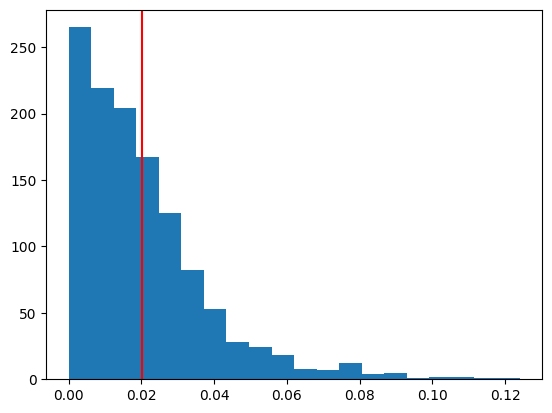

In [ ]:
plt.hist(row_tid_freq_simlist[row_freq_avgcos_df.loc[s_id_idx, 'table_id']], bins=20)
plt.axvline(x=row_freq_avgcos_df.loc[s_id_idx, 'avg-cosine-distance'], color='r')
plt.show()

In general, the selected embeddings which belongs to the s_table are truly similar to the r_table embeddings (with an average cosine distance near to 0.02) 

### Column querying

In [ ]:
col_res = column_collection.query(
    query_embeddings=r_column_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [ ]:
col_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(col_res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        col_tid_freq_simlist[single_rec['table_id']].append(col_res['distances'][i][j])

In [ ]:
col_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), col_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
col_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)

# discarding tables which appears only once, since they aren't actually significative
col_freq_avgcos_df[col_freq_avgcos_df['freq'] > 1].head()

,table_id,freq,avg-cosine-distance
2,16519520-1,5,0.000204
1,16559174-1,5,0.000513
3,16682980-1,4,0.001029
0,16717744-1,4,0.001802
7,19698915-1,2,0.005404


In [ ]:
s_id

'16519520-1'

### Conclusions

In [ ]:
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""16517223-1""","""16519520-1""",0.915589,1640,0.622627


We have found that in this case, the table with s_id="16519520-1" is the best one both with rows and columns, but on the rows part, it's very near to other results, in terms
of frequency and average similarity. Is this an indicator of a not-so-high true overlap ratio? 

## Test 3: Low Jaccard - Low Overlap

In [117]:
sloth_results[:10]

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491
"""16517223-1""","""16519520-1""",0.915589,1640,0.622627
"""16682980-1""","""16717744-1""",0.863576,1590,0.600907
"""16559174-1""","""16682980-1""",0.842894,1465,0.549925
"""16519520-1""","""16559174-1""",0.867637,1345,0.51063
"""16517223-1""","""16559174-1""",0.81258,1190,0.449735
"""16519520-1""","""16682980-1""",0.750777,1030,0.39104
"""16517223-1""","""16682980-1""",0.717855,910,0.343915
"""16517223-1""","""16717744-1""",0.657429,729,0.27551


In [126]:
idx_row = 9
sloth_result_rec = sloth_results[idx_row]
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""269064-2""","""3881235-1""",0.474112,640,0.302172


In [142]:
r_id = sloth_result_rec['r_id'].item()
s_id = sloth_result_rec['s_id'].item()
r_table = sloth_tables[r_id]
s_table = sloth_tables[s_id]

r_row_embeddings, r_column_embeddings = tabenc.full_embedding(r_table, True)
r_row_embeddings.shape, r_column_embeddings.shape 

((755, 300), (4, 300))

In [143]:
r_table.head()

,Lord,Party,Type,Notes
0,The Lord Aberdare,Crossbench,Excepted hereditary peer,
1,The Baroness Adams of Craigielea,Labour,Life peer,
2,The Lord Addington,Liberal Democrat,Excepted hereditary peer,
3,The Lord Adebowale,Crossbench,Life peer,Member of the Advisory Council on the Misuse o...
4,The Lord Adonis,Labour,Life peer,Former Secretary of State for Transport


In [144]:
s_table.head()

,Title,Creation,Other titles
0,The Lord Chalfont,1964,
1,The Baroness Masham of Ilton,1970,
2,The Lord Tanlaw,1971,
3,The Baroness Sharples,1973,
4,The Lord Mackie of Benshie,1974,


### Row querying

In [138]:
res = row_collection.query(
    query_embeddings=r_row_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [139]:
row_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        row_tid_freq_simlist[single_rec['table_id']].append(res['distances'][i][j])

In [148]:
row_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), row_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
row_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)
row_freq_avgcos_df = row_freq_avgcos_df[row_freq_avgcos_df['freq'] > 1]
row_freq_avgcos_df.head()

,table_id,freq,avg-cosine-distance
89,11976561-2,2,0.247149
95,663889-2,2,0.262573
90,9039166-2,4,0.264383
92,11950902-2,5,0.265302
41,661462-2,2094,0.267720


In [149]:
row_freq_avgcos_df[row_freq_avgcos_df['table_id'] == s_id]

,table_id,freq,avg-cosine-distance


In [ ]:
s_id_idx = 0
sloth_tables[row_freq_avgcos_df.loc[s_id_idx, 'table_id']]

### Column querying

In [151]:
col_res = column_collection.query(
    query_embeddings=r_column_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [152]:
col_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(col_res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        col_tid_freq_simlist[single_rec['table_id']].append(col_res['distances'][i][j])

In [153]:
col_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), col_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
col_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)

# discarding tables which appears only once, since they aren't actually significative
col_freq_avgcos_df[col_freq_avgcos_df['freq'] > 1].head()

,table_id,freq,avg-cosine-distance
25,29390830-8,2,0.114611
26,29390830-4,2,0.121321
0,3881235-1,2,0.193273
37,771758-1,4,0.356797
39,20461378-7,2,0.505278


In [156]:
s_id_idx = 0
col_freq_avgcos_df[col_freq_avgcos_df['table_id'] == s_id]

,table_id,freq,avg-cosine-distance
0,3881235-1,2,0.193273


In [157]:
col_tid_freq_simlist[s_id]

[0.0005834698677062988, 0.38596200942993164]

Here we have a very similar column, near to 0, and a very dissimilar columns: should be considered the variance in some kind of metrics?

### Conclusions

In [158]:
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""269064-2""","""3881235-1""",0.474112,640,0.302172


In questo caso in effetti le due tabelle non vengono ben relazionate: tra i confronti di riga la s_table non compare nemmeno, e tra quelli di colonna non risulta esseere la migliore, appunto per via della presenza di una seconda colonna con similarità bassa